In [28]:
from google.colab import drive
import zipfile
import os
import pandas as pd
from tqdm import tqdm

drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/ColabDatasets/IMU Dataset.zip'
extract_path = '/content'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

def find_subfolder_path(base_path, folder_name):
    for root, dirs, files in os.walk(base_path):
        if folder_name in dirs:
            return os.path.join(root, folder_name)
    return None

data_clean_path = find_subfolder_path(extract_path, 'data_clean')
label_path = find_subfolder_path(extract_path, 'label')

print("Resolved paths:")
print("data_clean_path:", data_clean_path)
print("label_path:", label_path)

if data_clean_path is None or label_path is None:
    raise FileNotFoundError("Couldn't find 'data_clean' or 'label' folders. Please check the ZIP contents.")

X = []
y = []

label_mapping = {
    0: "STATIC",
    1: "SLIDE_UP",
    2: "SLIDE_DOWN",
    3: "SLIDE_LEFT",
    4: "SLIDE_RIGHT",
    5: "RELEASE",
    6: "GRASP",
    10: "NONE"
}

print("\nSample files in data_clean_path:")
print(os.listdir(data_clean_path)[:5])

print("\nSample files in label_path:")
print(os.listdir(label_path)[:5])

for filename in tqdm(os.listdir(data_clean_path)):
    if filename.endswith('_data.csv'):
        data_file_path = os.path.join(data_clean_path, filename)
        label_filename = filename.replace('_data.csv', '_label.csv')
        label_file_path = os.path.join(label_path, label_filename)

        if not os.path.exists(label_file_path):
            print(f"Label file missing for: {filename}")
            continue

        data_df = pd.read_csv(data_file_path)
        label_df = pd.read_csv(label_file_path)
        label = int(label_df.iloc[0, 0])  # Get first label value

        X.append(data_df)
        y.append(label)

print(f"\n Loaded {len(X)} samples.")
if X:
    print(f"Example label: {y[0]} -> {label_mapping.get(y[0], 'UNKNOWN')}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Resolved paths:
data_clean_path: /content/rosbag/data/data_clean
label_path: /content/rosbag/data/label

Sample files in data_clean_path:
['rosbag2_2023_03_02-05_59_49_data.csv', 'rosbag2_2023_03_02-05_20_41_data.csv', 'rosbag2_2023_02_11-09_17_02_data.csv', 'rosbag2_2023_03_03-08_35_54_data.csv', 'rosbag2_2023_02_27-14_51_23_data.csv']

Sample files in label_path:
['rosbag2_2023_03_02-06_00_21_label.csv', 'rosbag2_2023_03_03-08_46_07_label.csv', 'rosbag2_2023_03_03-08_31_21_label.csv', 'rosbag2_2023_02_23-11_30_54_label.csv', 'rosbag2_2023_02_11-09_03_59_label.csv']


100%|██████████| 810/810 [00:03<00:00, 268.06it/s]


 Loaded 810 samples.
Example label: 3 -> SLIDE_LEFT


In [29]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import callbacks

feature_cols = [
    'Imu0_linear_accleration_x', 'Imu0_linear_accleration_y', 'Imu0_linear_accleration_z',
    'Imu0_angular_velocity_x', 'Imu0_angular_velocity_y', 'Imu0_angular_velocity_z'
]
FIXED_LENGTH = 100

X_processed = []
y_processed = []

for i in range(len(X)):
    df = X[i]
    if all(col in df.columns for col in feature_cols):
        values = df[feature_cols].values
        if values.shape[0] >= FIXED_LENGTH:
            trimmed = values[:FIXED_LENGTH]
            X_processed.append(trimmed)
            y_processed.append(y[i])
        else:
            padded = np.pad(values, ((0, FIXED_LENGTH - values.shape[0]), (0, 0)), mode='constant')
            X_processed.append(padded)
            y_processed.append(y[i])

unique_labels = sorted(list(set(y_processed)))
label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
y_encoded = np.array([label_mapping[label] for label in y_processed])

X_array = np.array(X_processed)
y_array = y_encoded

scaler = StandardScaler()
X_reshaped = X_array.reshape(-1, 6)
X_scaled = scaler.fit_transform(X_reshaped).reshape(-1, FIXED_LENGTH, 6)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_array, test_size=0.2, random_state=42)

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(FIXED_LENGTH, 6)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(len(label_mapping), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

best_model_path = "/content/best_gesture_model.h5"
checkpoint_callback = callbacks.ModelCheckpoint(
    filepath=best_model_path,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=25,
    batch_size=32,
    callbacks=[checkpoint_callback]
)

best_model = tf.keras.models.load_model(best_model_path)

def representative_dataset():
    for i in range(100):
        yield [X_train[i:i+1].astype(np.float32)]

converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_model = converter.convert()


tflite_path = "/content/gesture_model_quant.tflite"
with open(tflite_path, 'wb') as f:
    f.write(tflite_model)

print(f"Quantized TFLite model saved at: {tflite_path}")
print(f"Model size: {len(tflite_model) / 1024:.2f} KB")

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)             │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 16)             │         9,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 8)              │            72 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,824 (38.38 KB)

 Trainable params: 9,824 (38.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
16/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2247 - loss: 2.2087
Epoch 1: val_accuracy improved from -inf to 0.34568, saving model to /content/best_gesture_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.2372 - loss: 2.1592 - val_accuracy: 0.3457 - val_loss: 1.7385
Epoch 2/25
14/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3978 - loss: 1.6482 
Epoch 2: val_accuracy improved from 0.34568 to 0.40123, saving model to /content/best_gesture_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4064 - loss: 1.6226 - val_accuracy: 0.4012 - val_loss: 1.5754
Epoch 3/25
15/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4858 - loss: 1.4261 
Epoch 3: val_accuracy improved from 0.40123 to 0.46914, saving model to /content/best_gesture_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4969 - loss: 1.4087 - val_accuracy: 0.4691 - val_loss: 1.4438
Epoch 4/25
17/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5721 - loss: 1.2455 
Epoch 4: val_accuracy improved from 0.46914 to 0.51235, saving model to /content/best_gesture_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5809 - loss: 1.2386 - val_accuracy: 0.5123 - val_loss: 1.3092
Epoch 5/25
17/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6505 - loss: 1.0810 
Epoch 5: val_accuracy improved from 0.51235 to 0.60494, saving model to /content/best_gesture_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6507 - loss: 1.0817 - val_accuracy: 0.6049 - val_loss: 1.1559
Epoch 6/25
 1/21 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7188 - loss: 0.9204
Epoch 6: val_accuracy improved from 0.60494 to 0.65432, saving model to /content/best_gesture_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6996 - loss: 0.9634 - val_accuracy: 0.6543 - val_loss: 1.0511
Epoch 7/25
 1/21 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - accuracy: 0.7812 - loss: 0.6617
Epoch 7: val_accuracy improved from 0.65432 to 0.66049, saving model to /content/best_gesture_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7204 - loss: 0.8004 - val_accuracy: 0.6605 - val_loss: 0.9571
Epoch 8/25
 1/21 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - accuracy: 0.7812 - loss: 0.7234
Epoch 8: val_accuracy improved from 0.66049 to 0.71605, saving model to /content/best_gesture_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7291 - loss: 0.8309 - val_accuracy: 0.7160 - val_loss: 0.8828
Epoch 9/25
 1/21 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6875 - loss: 0.9405
Epoch 9: val_accuracy improved from 0.71605 to 0.75309, saving model to /content/best_gesture_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7357 - loss: 0.7530 - val_accuracy: 0.7531 - val_loss: 0.8145
Epoch 10/25
 1/21 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - accuracy: 0.8125 - loss: 0.5917
Epoch 10: val_accuracy improved from 0.75309 to 0.78395, saving model to /content/best_gesture_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7878 - loss: 0.6572 - val_accuracy: 0.7840 - val_loss: 0.7413
Epoch 11/25
20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7982 - loss: 0.6540  
Epoch 11: val_accuracy did not improve from 0.78395
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7997 - loss: 0.6509 - val_accuracy: 0.7778 - val_loss: 0.7131
Epoch 12/25
 1/21 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 0.8125 - loss: 0.5434
Epoch 12: val_accuracy improved from 0.78395 to 0.80247, saving model to /content/best_gesture_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8461 - loss: 0.5118 - val_accuracy: 0.8025 - val_loss: 0.6756
Epoch 13/25
 1/21 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7188 - loss: 0.6542
Epoch 13: val_accuracy did not improve from 0.80247
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8399 - loss: 0.4940 - val_accuracy: 0.8025 - val_loss: 0.6532
Epoch 14/25
 1/21 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9375 - loss: 0.2622
Epoch 14: val_accuracy improved from 0.80247 to 0.81481, saving model to /content/best_gesture_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8590 - loss: 0.4429 - val_accuracy: 0.8148 - val_loss: 0.6391
Epoch 15/25
 1/21 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - accuracy: 0.9062 - loss: 0.3706
Epoch 15: val_accuracy did not improve from 0.81481
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8672 - loss: 0.4627 - val_accuracy: 0.8148 - val_loss: 0.6259
Epoch 16/25
 1/21 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8750 - loss: 0.3192
Epoch 16: val_accuracy improved from 0.81481 to 0.83951, saving model to /content/best_gesture_model.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8772 - loss: 0.4328 - val_accuracy: 0.8395 - val_loss: 0.6047
Epoch 17/25
 1/21 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - accuracy: 0.9375 - loss: 0.2923
Epoch 17: val_accuracy did not improve from 0.83951
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8596 - loss: 0.4257 - val_accuracy: 0.8025 - val_loss: 0.6084
Epoch 18/25
 1/21 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8750 - loss: 0.4941
Epoch 18: val_accuracy did not improve from 0.83951
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8595 - loss: 0.4381 - val_accuracy: 0.8086 - val_loss: 0.6008
Epoch 19/25
 1/21 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8750 - loss: 0.4431
Epoch 19: val_accuracy did not improve from 0.83951
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8894 - loss: 0.3859 - val_accuracy: 0.8148 - val_loss: 0.5895
Epoch 20/25
 1/21 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - accuracy: 0.9062 - loss: 0.3365
Epoch 20: val_accuracy did not improve

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8972 - loss: 0.3652 - val_accuracy: 0.8457 - val_loss: 0.5708
Epoch 22/25
 1/21 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8750 - loss: 0.4095
Epoch 22: val_accuracy did not improve from 0.84568
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9005 - loss: 0.3564 - val_accuracy: 0.8457 - val_loss: 0.5534
Epoch 23/25
 1/21 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8750 - loss: 0.3903
Epoch 23: val_accuracy did not improve from 0.84568
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9102 - loss: 0.2837 - val_accuracy: 0.8395 - val_loss: 0.5495
Epoch 24/25
 1/21 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8438 - loss: 0.5124
Epoch 24: val_accuracy did not improve from 0.84568
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8852 - loss: 0.3357 - val_accuracy: 0.8395 - val_loss: 0.5513
Epoch 25/25
 1/21 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step - accuracy: 0.9062 - loss: 0.2866
Epoch 25: val_accuracy did not improve 

Saved artifact at '/tmp/tmp7eol35dm'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100, 6), dtype=tf.float32, name='input_layer_3')
Output Type:
  TensorSpec(shape=(None, 8), dtype=tf.float32, name=None)
Captures:
  138639555209808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138639555207696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138639555210000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138639555201744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138639555200592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138639555203664: TensorSpec(shape=(), dtype=tf.resource, name=None)
Quantized TFLite model saved at: /content/gesture_model_quant.tflite
Model size: 13.15 KB


/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [30]:
import tensorflow as tf
import numpy as np

interpreter = tf.lite.Interpreter(model_path='gesture_model_quant.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_scale, input_zero_point = input_details[0]['quantization']
output_scale, output_zero_point = output_details[0]['quantization']

correct = 0
for i in range(len(X_test)):
    input_data = X_test[i:i+1].astype(np.float32)
    input_data = input_data / input_scale + input_zero_point
    input_data = np.clip(np.round(input_data), -128, 127).astype(np.int8)

    interpreter.set_tensor(input_details[0]['index'], input_data)

    interpreter.invoke()

    output_data = interpreter.get_tensor(output_details[0]['index'])
    pred = np.argmax(output_data[0])

    if pred == y_test[i]:
        correct += 1

tflite_accuracy = correct / len(X_test)
print(f" TFLite Quantized Model Accuracy: {tflite_accuracy * 100:.2f}%")


 TFLite Quantized Model Accuracy: 84.57%


In [31]:
noise_std = 0.01

X_test_noisy = X_test + np.random.normal(0, noise_std, X_test.shape)
X_test_noisy = np.clip(X_test_noisy, -3, 3)

correct_noisy = 0
for i in range(len(X_test_noisy)):
    input_data = X_test_noisy[i:i+1].astype(np.float32)
    input_data = input_data / input_scale + input_zero_point
    input_data = np.clip(np.round(input_data), -128, 127).astype(np.int8)

    interpreter.set_tensor(input_details[0]['index'], input_data)

    interpreter.invoke()

    output_data = interpreter.get_tensor(output_details[0]['index'])
    pred = np.argmax(output_data[0])

    if pred == y_test[i]:
        correct_noisy += 1

tflite_accuracy_noisy = correct_noisy / len(X_test_noisy)
print(f" TFLite Model Accuracy with Noise (std={noise_std}): {tflite_accuracy_noisy * 100:.2f}%")


 TFLite Model Accuracy with Noise (std=0.01): 82.10%


In [32]:
X_test_shifted = X_test.copy()
missing_rate = 0.1
for i in range(len(X_test_shifted)):
    if np.random.rand() < missing_rate:
        X_test_shifted[i, :, :] = 0

correct_shifted = 0
for i in range(len(X_test_shifted)):
    input_data = X_test_shifted[i:i+1].astype(np.float32)
    input_data = input_data / input_scale + input_zero_point
    input_data = np.clip(np.round(input_data), -128, 127).astype(np.int8)

    interpreter.set_tensor(input_details[0]['index'], input_data)

    interpreter.invoke()

    output_data = interpreter.get_tensor(output_details[0]['index'])
    pred = np.argmax(output_data[0])

    if pred == y_test[i]:
        correct_shifted += 1

tflite_accuracy_shifted = correct_shifted / len(X_test_shifted)
print(f" TFLite Model Accuracy with Temporal Shifts (missing data): {tflite_accuracy_shifted * 100:.2f}%")


 TFLite Model Accuracy with Temporal Shifts (missing data): 77.16%


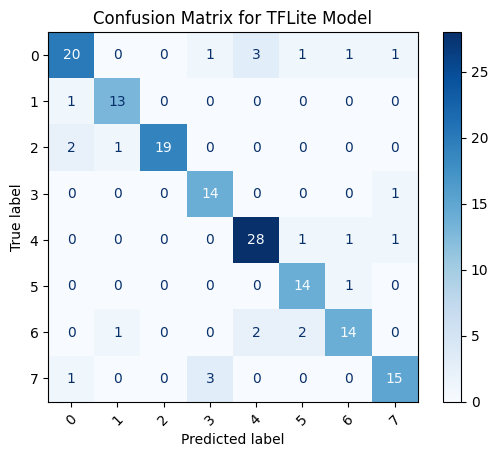

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

y_pred = []
for i in range(len(X_test)):
    input_data = X_test[i:i+1].astype(np.float32)
    input_data = input_data / input_scale + input_zero_point
    input_data = np.clip(np.round(input_data), -128, 127).astype(np.int8)

    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()

    output_data = interpreter.get_tensor(output_details[0]['index'])
    pred = np.argmax(output_data[0])
    y_pred.append(pred)

y_pred = np.array(y_pred)

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[label_mapping[l] for l in sorted(label_mapping.keys())])
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title('Confusion Matrix for TFLite Model')
plt.show()


In [34]:
from sklearn.metrics import classification_report

y_test_str = [label_mapping.get(label, str(label)) for label in y_test]
y_pred_str = [label_mapping.get(label, str(label)) for label in y_pred]

target_names = [str(label_mapping[l]) for l in sorted(label_mapping.keys())]
report = classification_report(y_test_str, y_pred_str, target_names=target_names)
print(" Per-Class Metrics (Precision, Recall, F1-Score):\n")
print(report)

 Per-Class Metrics (Precision, Recall, F1-Score):

              precision    recall  f1-score   support

           0       0.83      0.74      0.78        27
           1       0.87      0.93      0.90        14
           2       1.00      0.86      0.93        22
           3       0.78      0.93      0.85        15
           4       0.85      0.90      0.88        31
           5       0.78      0.93      0.85        15
           6       0.82      0.74      0.78        19
           7       0.83      0.79      0.81        19

    accuracy                           0.85       162
   macro avg       0.85      0.85      0.85       162
weighted avg       0.85      0.85      0.84       162



In [35]:

X_test_partial = []
y_test_partial = []
for i in range(len(X_test)):
    partial_sequence = X_test[i][:int(FIXED_LENGTH * 0.5)]
    padded_sequence = np.pad(partial_sequence, ((0, FIXED_LENGTH - len(partial_sequence)), (0, 0)), mode='constant')

    X_test_partial.append(padded_sequence)
    y_test_partial.append(y_test[i])

X_test_partial = np.array(X_test_partial)

correct_partial = 0

for i in range(len(X_test_partial)):
    input_data = X_test_partial[i:i+1].astype(np.float32)
    input_data = input_data / input_scale + input_zero_point
    input_data = np.clip(np.round(input_data), -128, 127).astype(np.int8)

    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()

    output_data = interpreter.get_tensor(output_details[0]['index'])
    pred = np.argmax(output_data[0])

    if pred == y_test_partial[i]:
        correct_partial += 1

accuracy_partial = correct_partial / len(X_test_partial)
print(f" TFLite Model Accuracy with Partial Gestures: {accuracy_partial * 100:.2f}%")


 TFLite Model Accuracy with Partial Gestures: 48.77%


In [36]:

model_fp = tf.keras.models.load_model(best_model_path)

def check_quantization_error():
    error_count = 0
    for i in range(len(X_test)):
        fp_pred = np.argmax(model_fp.predict(X_test[i:i+1]), axis=1)

        input_data = X_test[i:i+1].astype(np.float32)
        input_data = input_data / input_scale + input_zero_point
        input_data = np.clip(np.round(input_data), -128, 127).astype(np.int8)

        interpreter.set_tensor(input_details[0]['index'], input_data)
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[0]['index'])
        tflite_pred = np.argmax(output_data[0])

        if fp_pred != tflite_pred:
            error_count += 1

    quantization_error_rate = error_count / len(X_test) * 100
    print(f"Quantization Error Rate: {quantization_error_rate:.2f}%")

check_quantization_error()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━